In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
from pinns import *
from local_utils import *

from pinns import *
from intro import *

In [2]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
dev_str = f"{device.type}:{device.index}"

In [3]:
import pickle
with open(f"./inputs/solution_9.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

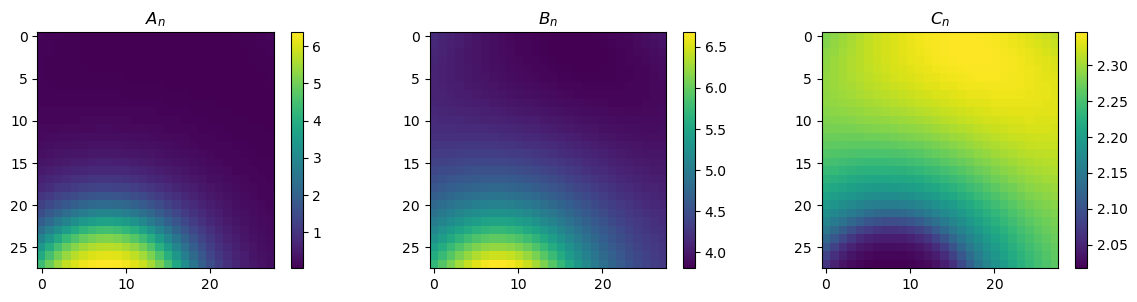

In [4]:
A_n = solution[150, 0, :, :]
B_n = solution[150, 1, :, :]
C_n = solution[150, 2, :, :]

#############################################################
#    Inner boundaries
# By using these slices, we can remove the boundary effects
# or select a smaller portion of the domain
#
#   Important: slices must not be larger than slices(1,-1,1).
#              Otherwise, the boundary effects of finit difference
#              Laplacian cannot be removed
#
x_slice = slice(50,-50, 1)
y_slice = slice(50,-50, 1)

to = create_to(A_n[x_slice,y_slice])
############################################################
plot_n_im([A_n[x_slice,y_slice], 
           B_n[x_slice,y_slice], 
           C_n[x_slice,y_slice]], 
          [r"$A_{n}$", r"$B_{n}$", r"$C_{n}$"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

Epoch: 1 
 data loss:1.137425, 
data A loss:0.645765, data B loss:0.403559, data C loss:0.088101, 
Laplacian A loss:8.072447, Laplacian B loss:1.876395
Negative loss:0.310196




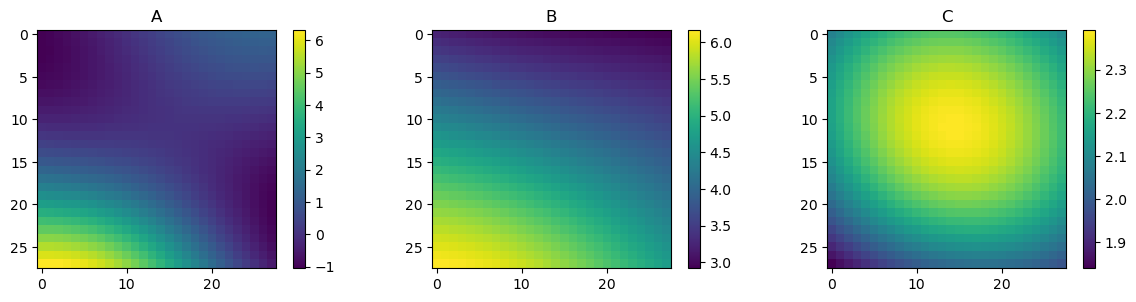

Epoch: 100 
 data loss:0.006978, 
data A loss:0.002350, data B loss:0.000614, data C loss:0.004014, 
Laplacian A loss:0.006616, Laplacian B loss:0.007967
Negative loss:0.000000




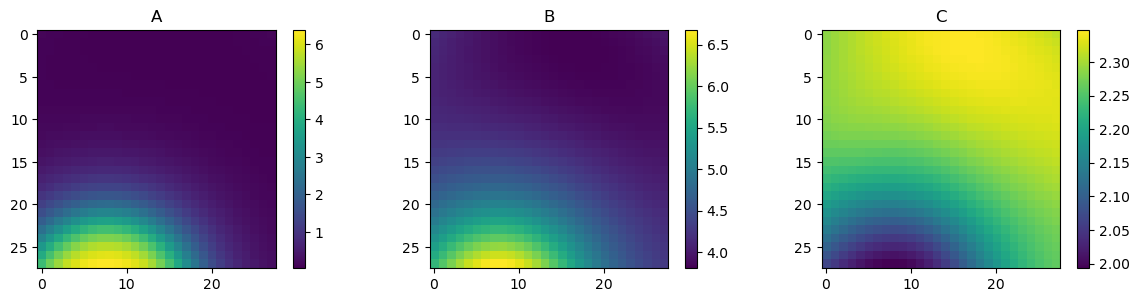

Epoch: 200 
 data loss:0.005614, 
data A loss:0.002283, data B loss:0.000509, data C loss:0.002822, 
Laplacian A loss:0.006268, Laplacian B loss:0.006721
Negative loss:0.000000




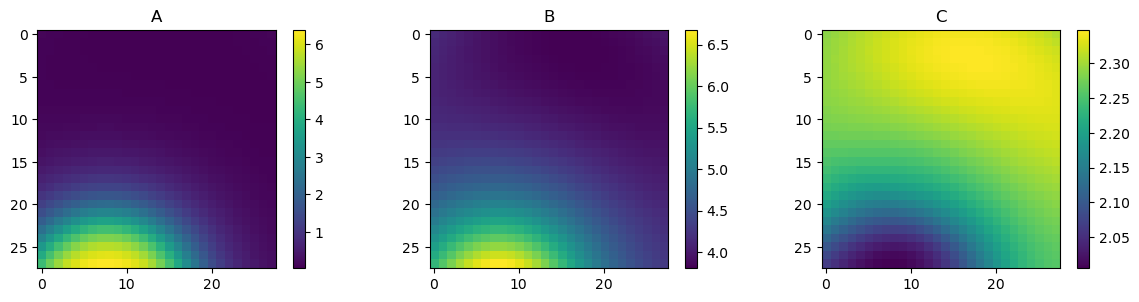

Epoch: 300 
 data loss:0.005614, 
data A loss:0.002283, data B loss:0.000509, data C loss:0.002822, 
Laplacian A loss:0.006268, Laplacian B loss:0.006721
Negative loss:0.000000




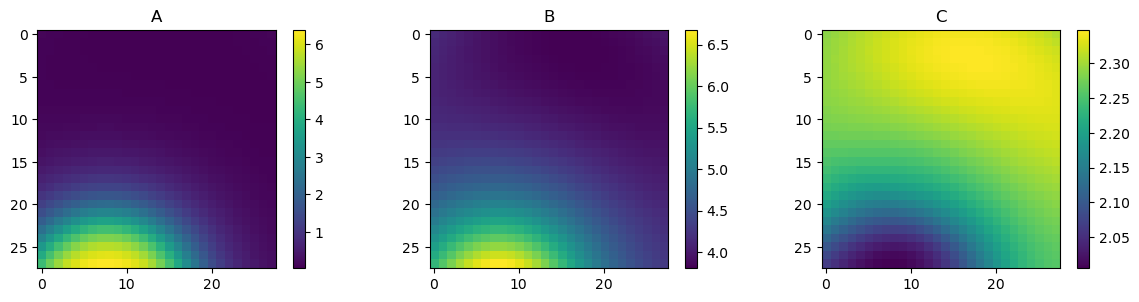

Epoch: 400 
 data loss:0.005614, 
data A loss:0.002283, data B loss:0.000509, data C loss:0.002822, 
Laplacian A loss:0.006268, Laplacian B loss:0.006721
Negative loss:0.000000




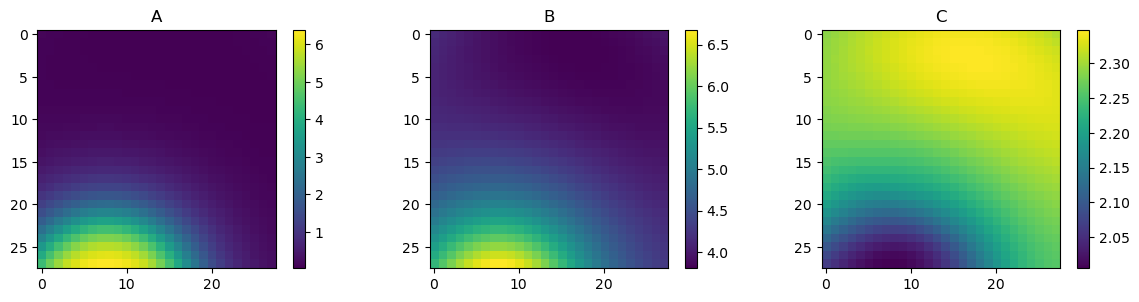

Epoch: 500 
 data loss:0.005614, 
data A loss:0.002283, data B loss:0.000509, data C loss:0.002822, 
Laplacian A loss:0.006268, Laplacian B loss:0.006721
Negative loss:0.000000




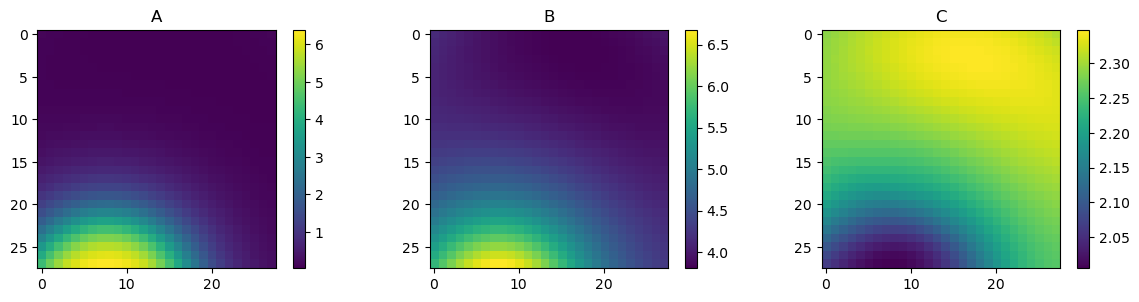

In [5]:
torch.manual_seed(42)
np.random.seed(42)
dtype = torch.float32
torch.set_default_dtype(dtype)

###########################################################
# Inputs
# restrict to inner boundaries
x = torch.linspace(0, run_params.Lx, run_params.Ix)[x_slice].to(device)
y = torch.linspace(0, run_params.Ly, run_params.Jy)[y_slice].to(device)
X,Y = torch.meshgrid(x, y, indexing='ij')
data_X = torch.vstack([X.flatten(), Y.flatten()]).T.requires_grad_(True).to(device)
##########################################################
#   Data
# restrict to inner boundaries
data_A = torch.from_numpy(A_n[x_slice,y_slice].flatten()).to(device)
data_B = torch.from_numpy(B_n[x_slice,y_slice].flatten()).to(device)
data_C = torch.from_numpy(C_n[x_slice,y_slice].flatten()).to(device)
###########################################################
# Laplacians
# First, find the finite-diff Laplacian on the whole domain,
# then, select the inner boundaries. This way, the boundaries 
# effets removed
diffusion_scale_factor = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
laplacianA = diffusion_scale_factor * grad_diff(A_n)
laplacianB = diffusion_scale_factor * grad_diff(B_n)

laplacianA = torch.tensor(laplacianA[x_slice,y_slice].flatten()).to(device)
laplacianB = torch.tensor(laplacianB[x_slice,y_slice].flatten()).to(device)
###########################################################
zeors_tensor = torch.zeros(data_X.shape[0]).to(device)
###########################################################
# Model
lb = torch.tensor([torch.min(x).item(), torch.min(y).item()]).to(device)
ub = torch.tensor([torch.max(x).item(), torch.max(y).item()]).to(device)
model = Net_sep_dense_normalised(2,3,[800,800,800,800], lb, ub).to(device)
###########################################################
# optimizer
optimizer = torch.optim.LBFGS([*model.parameters()], lr=1
                             ,line_search_fn='strong_wolfe')#.Adam([*model.parameters()], lr=1e-4)#


epochs = 500
loss_data = 0.0
lambda_data = 1.0
loss_physics = 0.0
lambda_physics_laplacian = 1e-2
loss_negative = 0
lambda_negative = 100

losses = np.zeros((6, epochs))

def act(x, km, n=2):
    return x**n / (x**n + km**n)

def inh(x, km, n=2):
    return  km**n / (x**n + km**n)

# last_loss = np.inf
# early_stop = False
for i in range(epochs ):
    flg_new_call = True
    # L-BFGS
    def closure():
        
        optimizer.zero_grad()

        #################################
        # data loss
        data_f_hat = model(data_X)
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        loss_A_data = torch.mean((data_A - data_A_hat)**2)
        loss_B_data = torch.mean((data_B - data_B_hat)**2)
        loss_C_data = torch.mean((data_C - data_C_hat)**2)
        loss_data = (loss_A_data + loss_B_data + loss_C_data)/3
        #################################
        loss_negative = torch.mean(torch.maximum(-data_A_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_B_hat, zeors_tensor)**2
                       )+ torch.mean(torch.maximum(-data_C_hat, zeors_tensor)**2
                       )
        #################################
        # physics derivatives
        A = data_A_hat
        B = data_B_hat
        C = data_C_hat

        laplacianA_hat = Laplacian(A, data_X)
        laplacianB_hat = Laplacian(B, data_X)
        
        A_loss_laplacian = torch.mean((laplacianA_hat-laplacianA)**2)
        B_loss_laplacian = torch.mean((laplacianB_hat-laplacianB)**2)
        loss_laplacian_physics = A_loss_laplacian + B_loss_laplacian
        ###############################
        total_loss = (
            +lambda_data*loss_data            
            +lambda_physics_laplacian*loss_laplacian_physics
            #+lambda_negative*loss_negative
                        )

        total_loss.backward(retain_graph=True)
        
        
        losses[:,i] = (loss_A_data.item(), loss_B_data.item(), loss_C_data.item(), 
                       A_loss_laplacian.item(), B_loss_laplacian.item(),
                       loss_negative.item())                    
            
        return total_loss
    
    
    
    optimizer.step(closure)
#     if i < epochs and last_loss > np.sum(losses[:,i]):
#         last_loss =  np.sum(losses[:,i])
#         if i > 200:
#             torch.save(model.state_dict(), "./04_outputs/model_LBFGS_Field_only_non_stationary_31")
            
#     elif np.sum(losses[:,i]) < last_loss:
#         ls = np.sqrt(losses[:, i])
#         print("============================================")
#         print(f"Stoped at {i+1}")
#         print("============================================")
#         print(f"Epoch: {i+1} \n data loss:{np.sum(ls[0:3]):.6f}, \n"
#               f"data A loss:{ls[0]:.6f}, data B loss:{ls[1]:.6f}, data C loss:{ls[2]:.6f}, \n"
#               f"Laplacian A loss:{ls[3]:.6f}, Laplacian B loss:{ls[4]:.6f}\n"
#               f"Negative loss:{ls[5]:.6f}\n"
#               f"\n"
#              )
#         data_f_hat = model(data_X)        
#         data_A_hat = data_f_hat[0].squeeze() 
#         data_B_hat = data_f_hat[1].squeeze() 
#         data_C_hat = data_f_hat[2].squeeze() 
#         plot_n_im([to(data_A_hat.cpu().detach().numpy()), 
#                    to(data_B_hat.cpu().detach().numpy()), 
#                    to(data_C_hat.cpu().detach().numpy())], 
#            ["A","B","C"],          
#         figsize=(12, 3)); plt.tight_layout();plt.show() 
#         early_stop = True
#         break
    
    if (i+1)%100 == 0 or i==0 :
        ls = np.sqrt(losses[:, i])
        print("============================================")
        print(f"Epoch: {i+1} \n data loss:{np.sum(ls[0:3]):.6f}, \n"
              f"data A loss:{ls[0]:.6f}, data B loss:{ls[1]:.6f}, data C loss:{ls[2]:.6f}, \n"
              f"Laplacian A loss:{ls[3]:.6f}, Laplacian B loss:{ls[4]:.6f}\n"
              f"Negative loss:{ls[5]:.6f}\n"
              f"\n"
             )
        data_f_hat = model(data_X)        
        data_A_hat = data_f_hat[0].squeeze() 
        data_B_hat = data_f_hat[1].squeeze() 
        data_C_hat = data_f_hat[2].squeeze() 
        plot_n_im([to(data_A_hat.cpu().detach().numpy()), 
                   to(data_B_hat.cpu().detach().numpy()), 
                   to(data_C_hat.cpu().detach().numpy())], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 
        
# if not early_stop:
#     model = Net_sep_dense_normalised(2,3,[ 512, 512, 512], lb, ub)
#     model.load_state_dict(torch.load("./04_outputs/model_LBFGS_Field_only_non_stationary_31"))
#     model.to(device)

# Plot the trained outputs

A RMSE:0.0022834280252143815 B RMSE:0.0005089379338111301 C RMSE:0.002822011541917664
F_A actual:0.010373344320593114, F_A:0.010340936481952667, RMSE: 0.0003666600862602697
F_B actual:4.25869107836922, F_B:4.2514214515686035, RMSE: 0.006100771618981177
F_C actual:9.753714681941717e-12, F_C:0.00011259838356636465, RMSE: 0.010611126344186757

Laplacian A RMSE: 0.006268075453273695
Laplacian B RMSE: 0.006720738485065456

dAdt RMSE: 0.0003705361146515879
dBdt RMSE: 0.008854905060622099
dCdt RMSE: 0.010611126344186757


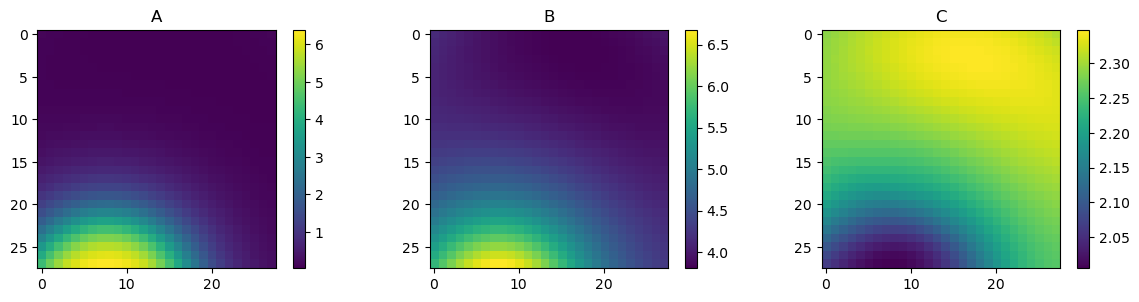

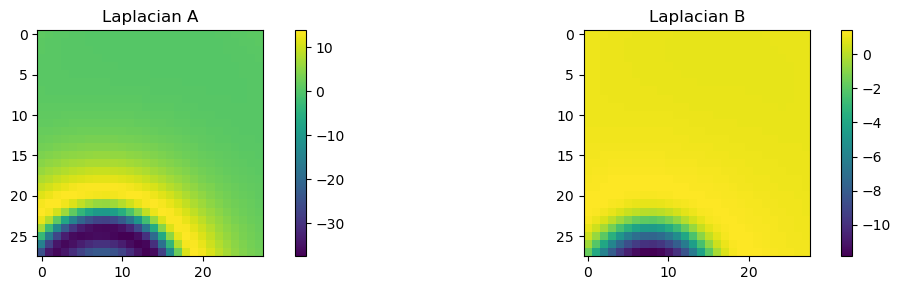

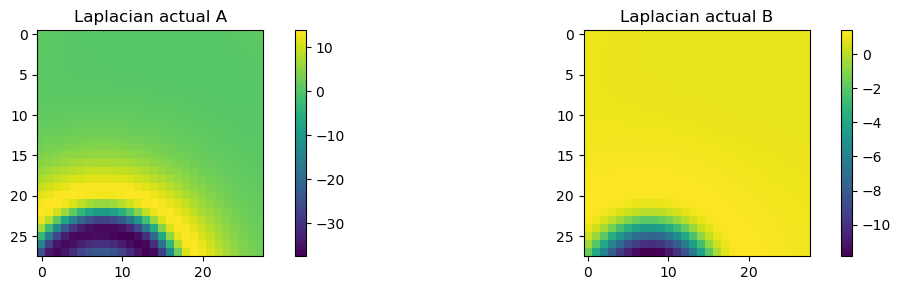

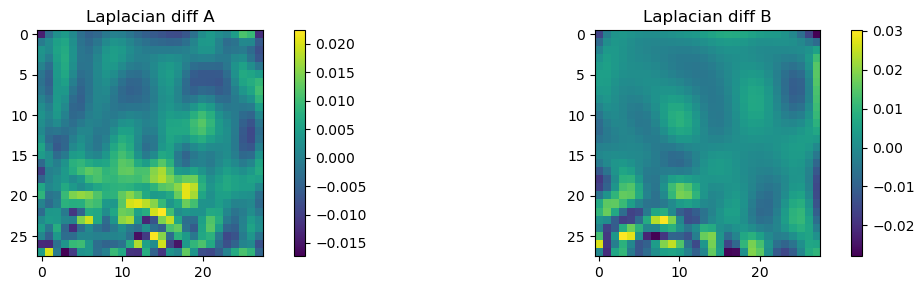

In [6]:
physics_f = model(data_X)
A_hat = physics_f[0].squeeze()
B_hat = physics_f[1].squeeze()
C_hat = physics_f[2].squeeze()

laplacianA_hat = Laplacian(A_hat, data_X)
laplacianB_hat = Laplacian(B_hat, data_X)

A_hat = to(A_hat.cpu().detach().numpy())
B_hat = to(B_hat.cpu().detach().numpy())
C_hat = to(C_hat.cpu().detach().numpy())
laplacianA_hat = to(laplacianA_hat.cpu().detach().numpy())
laplacianB_hat = to(laplacianB_hat.cpu().detach().numpy())


laplacianA = diffusion_scale_factor * grad_diff(A_n)[x_slice,y_slice]
laplacianB = diffusion_scale_factor * grad_diff(B_n)[x_slice,y_slice]

n = params["n"]

A = A_n[x_slice,y_slice]
B = B_n[x_slice,y_slice]
C = C_n[x_slice,y_slice]

F_A =  params["b_A"] + params["V_A"]*act(A, params["K_AA"], n)*inh(B, params["K_BA"], n) - params["mu_A"] * A
F_A_hat =  params["b_A"] + params["V_A"]*act(A_hat, params["K_AA"], n)*inh(B_hat, params["K_BA"], n) - params["mu_A"] * A_hat
F_B =  params["b_B"] + params["V_B"]*act(A, params["K_AB"], n)*inh(C, params["K_CB"], n) - params["mu_B"] * B
F_B_hat =  params["b_B"] + params["V_B"]*act(A_hat, params["K_AB"], n)*inh(C_hat, params["K_CB"], n) - params["mu_B"] * B_hat
F_C =  params["b_C"] + params["V_C"]*inh(A, params["K_AC"], n)*inh(B, params["K_BC"], n)*act(C, params["K_CC"], n) - params["mu_C"] * C
F_C_hat =  params["b_C"] + params["V_C"]*inh(A_hat, params["K_AC"], n)*inh(B_hat, params["K_BC"], n)*act(C_hat, params["K_CC"], n) - params["mu_C"] * C_hat


dAdt = params["D_A"]*laplacianA + F_A
dAdt_hat = params["D_A"]*laplacianA_hat + F_A_hat
dBdt = params["D_B"]*laplacianB + F_B
dBdt_hat = params["D_B"]*laplacianB_hat + F_B_hat

print(f"A RMSE:{np.sqrt(np.mean((A_hat-A)**2))}",
      f"B RMSE:{np.sqrt(np.mean((B_hat-B)**2))}",
      f"C RMSE:{np.sqrt(np.mean((C_hat-C)**2))}")

print(f"F_A actual:{np.mean(F_A**2)}, F_A:{np.mean(F_A_hat**2)}, RMSE: {np.sqrt(np.mean((F_A - F_A_hat)**2))}")
print(f"F_B actual:{np.mean(F_B**2)}, F_B:{np.mean(F_B_hat**2)}, RMSE: {np.sqrt(np.mean((F_B - F_B_hat)**2))}")
print(f"F_C actual:{np.mean(F_C**2)}, F_C:{np.mean(F_C_hat**2)}, RMSE: {np.sqrt(np.mean((F_C - F_C_hat)**2))}")
      

print()
print(f"Laplacian A RMSE: {np.sqrt(np.mean((laplacianA_hat-laplacianA)**2))}")
print(f"Laplacian B RMSE: {np.sqrt(np.mean((laplacianB_hat-laplacianB)**2))}")

print()
print(f"dAdt RMSE: {np.sqrt(np.mean((dAdt-dAdt_hat)**2))}")
print(f"dBdt RMSE: {np.sqrt(np.mean((dBdt-dBdt_hat)**2))}")
print(f"dCdt RMSE: {np.sqrt(np.mean((F_C-F_C_hat)**2))}")

plot_n_im([A_hat, B_hat, C_hat], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()


plot_n_im([laplacianA_hat, laplacianB_hat], 
          ["Laplacian A", "Laplacian B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA, laplacianB], 
          ["Laplacian actual A", "Laplacian actual B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()

plot_n_im([laplacianA_hat-laplacianA, laplacianB_hat-laplacianB], 
          ["Laplacian diff A", "Laplacian diff B"],          
          figsize=(12, 3)); plt.tight_layout();plt.show()



# Plot losses

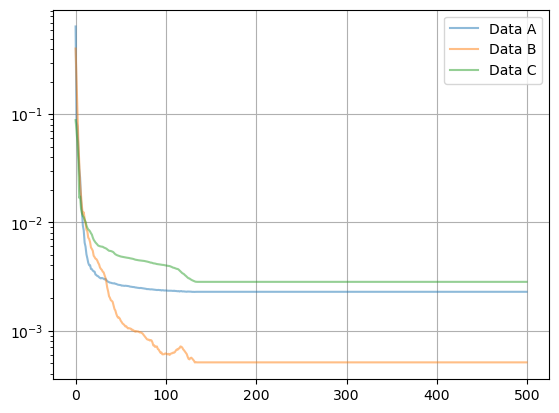

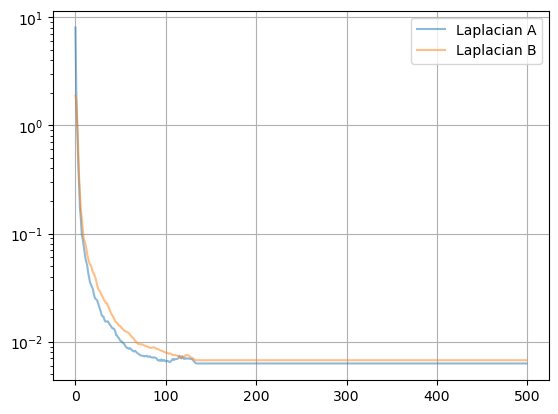

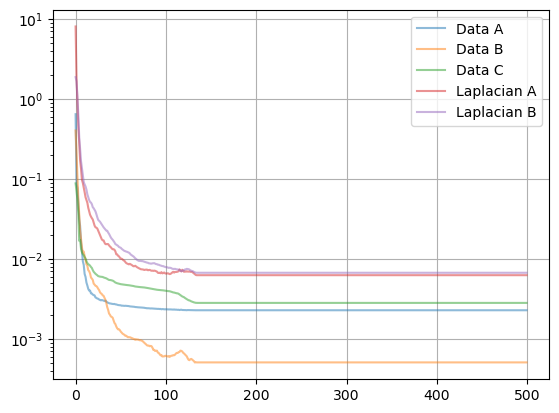

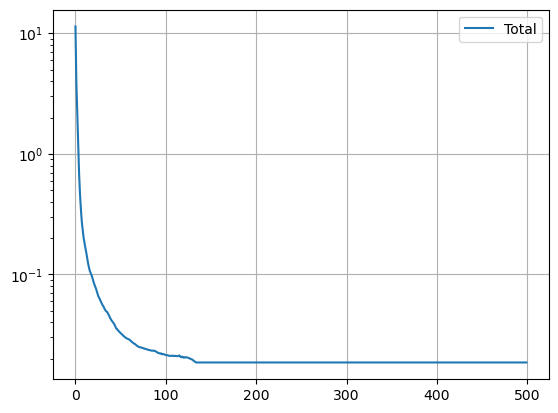

In [7]:
ls= np.sqrt(losses)
plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.yscale('log');plt.grid();plt.legend();plt.show()

plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log');plt.grid();plt.legend();plt.show()


plt.plot(ls[0,:], alpha=.5, label="Data A")
plt.plot(ls[1,:], alpha=.5, label="Data B")
plt.plot(ls[2,:], alpha=.5, label="Data C")
plt.plot(ls[3,:], alpha=.5, label="Laplacian A")
plt.plot(ls[4,:], alpha=.5, label="Laplacian B")
plt.yscale('log'); plt.grid();plt.legend();plt.show()

plt.plot(np.sum(ls, axis=0), label="Total")
plt.yscale('log'); plt.grid();plt.legend();plt.show()


# Plot the trained Field and its difference

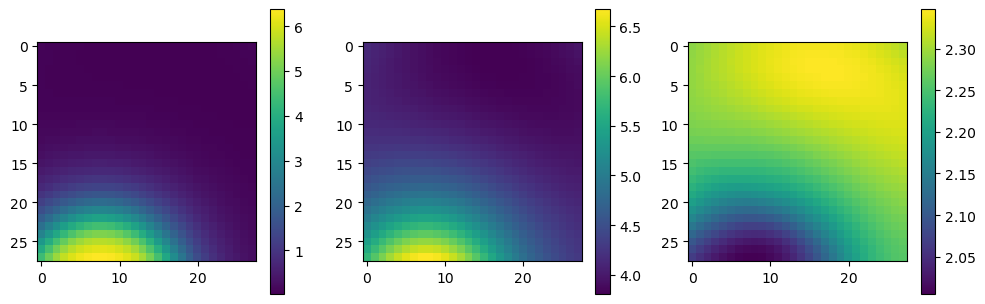

In [8]:
solution_hat = model(data_X)
A_hat = to(solution_hat[0].cpu().detach().numpy())
B_hat = to(solution_hat[1].cpu().detach().numpy())
C_hat = to(solution_hat[2].cpu().detach().numpy())
_ = plt.figure(figsize=(10,6))
plt.subplot(131)
plt.imshow(A_hat)
plt.colorbar(shrink=.5)
plt.subplot(132)
plt.imshow(B_hat)
plt.colorbar(shrink=.5)
plt.subplot(133)
plt.imshow(C_hat)
plt.colorbar(shrink=.5)
plt.tight_layout()
plt.show()

5.214043546334449e-06
2.590178204719423e-07
7.963749142716512e-06


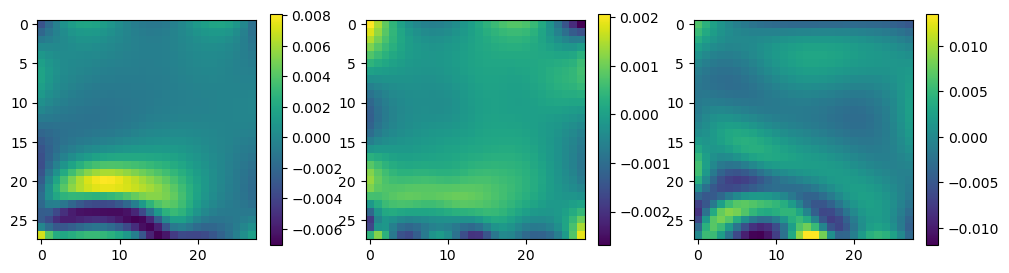

In [9]:
_ = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(A_hat-A)
print(np.mean((A_hat-A)**2))
plt.colorbar(shrink=.75)
plt.subplot(132)
plt.imshow(B_hat-B)
print(np.mean((B_hat-B)**2))
plt.colorbar(shrink=.75)
plt.subplot(133)
plt.imshow(C_hat-C)
print(np.mean((C_hat-C)**2))
plt.colorbar(shrink=.75)
plt.show()

# Second optimisation
## Find the parameters

In [10]:
physics_f = model(data_X)
A_hat = physics_f[0].squeeze()
B_hat = physics_f[1].squeeze()
C_hat = physics_f[2].squeeze()

laplacianA_hat = to(Laplacian(A_hat, data_X).cpu().detach().numpy().astype(np.float64))
laplacianB_hat = to(Laplacian(B_hat, data_X).cpu().detach().numpy().astype(np.float64))

A_hat = to(A_hat.cpu().detach().numpy().astype(np.float64))
B_hat = to(B_hat.cpu().detach().numpy().astype(np.float64))
C_hat = to(C_hat.cpu().detach().numpy().astype(np.float64))

# A_hat = A_n[1:-1, 1:-1]#[x_slice, y_slice]
# B_hat = B_n[1:-1, 1:-1]#[x_slice, y_slice]
# C_hat = C_n[1:-1, 1:-1]#[x_slice, y_slice]

diffusion_scale_factor = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
laplacianA = diffusion_scale_factor * grad_diff(A_n)
laplacianB = diffusion_scale_factor * grad_diff(B_n)

laplacianA_hat = laplacianA[x_slice, y_slice]
laplacianB_hat = laplacianB[x_slice, y_slice]
    
D_A=params["D_A"]
D_B=params["D_B"]
n = params['n']
mu_C=params["D_A"]

A_min, A_max = np.min(A_hat), np.max(A_hat)
B_min, B_max = np.min(B_hat), np.max(B_hat)
C_min, C_max = np.min(C_hat), np.max(C_hat)
tol = .01

def define_bound(tol, n, x_min, x_max):
    upper = ((1-tol)/tol)**(1/n)
    lower = (tol/(1-tol))**(1/n)
    # return (lower, upper) bounds and the initial guess
    return (max(0,x_min*lower), x_max*upper), max(0, (x_max*upper-max(0,x_min*lower))/2)
    
K_AA_bound, K_AA_init =  define_bound(tol, n, A_min, A_max)
K_AB_bound, K_AB_init =  define_bound(tol, n, A_min, A_max)
K_AC_bound, K_AC_init =  define_bound(tol, n, A_min, A_max)
K_BA_bound, K_BA_init =  define_bound(tol, n, B_min, B_max)
K_BC_bound, K_BC_init =  define_bound(tol, n, B_min, B_max)
K_CB_bound, K_CB_init =  define_bound(tol, n, C_min, C_max)
K_CC_bound, K_CC_init =  define_bound(tol, n, C_min, C_max)


b_A =1#0005#params["b_A"]# 0
b_B =1# 0.5#params["b_B"]#0
b_C =1# 0.5#params["b_C"]#0
V_A =1# 4#params["V_A"]#0
V_B =1# 19#params["V_B"]#0
V_C =1# 19#params["V_C"]#0
mu_A =1# 0.05#params["mu_A"]#
mu_B =1# .4#params["mu_B"]#

K_AA = K_AA_init#params["K_AA"]#K_AA_init
K_AB = K_AB_init#params["K_AB"]#K_AB_init
K_AC = K_AC_init#params["K_AC"]#K_AC_init
K_BA = K_BA_init#params["K_BA"]#K_BA_init
K_BC = K_BC_init#params["K_BC"]#K_BC_init
K_CB = K_CB_init#params["K_CB"]#K_CB_init
K_CC = K_CC_init


params_name_list = [#"D_A", "D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", #"mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", 
                    "K_CC"
]

params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC
]

def physics_loss(args):            
    (b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC) = args
 

    F_A_hat =  b_A + V_A*act(A_hat, K_AA, n)*inh(B_hat, K_BA, n) - mu_A * A_hat
    #f_A =  e(b_A)/(e(D_A)+1e-6) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n)/(e(D_A)+1e-6) - e(mu_A)*A/(e(D_A)+1e-6)
    F_B_hat =  b_B + V_B*act(A_hat, K_AB, n)*inh(C_hat, K_CB, n) - mu_B * B_hat
    #f_B =  e(b_B)/(e(D_B)+1e-6) + e(V_B)*act(A, e(K_AB), n)*inh(C, e(K_CB), n)/(e(D_B)+1e-6) - e(mu_B)*B/(e(D_B)+1e-6)
    F_C_hat =  b_C + V_C*inh(A_hat, K_AC, n)*inh(B_hat, K_BC, n)*act(C_hat, K_CC, n) - mu_C * C_hat

    
    #dAdt = e(D_A) * laplacianA + F_A
    dAdt = D_A * laplacianA_hat + F_A_hat
    #dAdt2 = laplacianA + f_A
    #dBdt = e(D_B) * laplacianB + F_B
    dBdt = D_B * laplacianB_hat + F_B_hat
    #dBdt2 = laplacianB + f_B
    dCdt = F_C_hat
    ################################
    # physics loss
    # Construct the physics loss here
    A_loss_physics = np.mean(dAdt**2)
    #A2_loss_physics = torch.mean(dAdt2**2)
    B_loss_physics = np.mean(dBdt**2)
    #B2_loss_physics = torch.mean(dBdt2**2)
    C_loss_physics = np.mean(dCdt**2)
    
    return (A_loss_physics + B_loss_physics + C_loss_physics)
i = 0
def print_callback(x):
    global i
    
    if (i+1)%100 == 0 or i == 0:
        print(f"iteration:{i+1}, loss: {physics_loss(x):.8f} ", 
          f", ".join([f"{name}={l:.4f}" 
                 for l, name in zip(x, params_name_list)]))
    i += 1
from scipy.optimize import minimize

bounds = [(0, None),(0, None),(0, None), # b_A, b_B, b_C
          (0, None),(0, None),(0, None), # V_A, V_B, V_C
          (0, None),(0, None), # mu_A, mu_B
          K_AA_bound, K_AB_bound, K_AC_bound,
          K_BA_bound, K_BC_bound,
          K_CB_bound,
          K_CC_bound,
         ]

res = minimize(physics_loss, params_list, bounds=bounds,
               tol=1e-16,
               options={'maxiter':2e4, 'maxfun':1e6},
               method="L-BFGS-B",#"L-BFGS-B",#"Nelder-Mead",# 
               callback=print_callback)
print("==============================================")
i=0
bounds = [(0, None) for _ in params_list]
res_unbound = minimize(physics_loss, params_list, bounds=bounds,
               tol=1e-16,
               options={'maxiter':2e4, 'maxfun':1e6},
               method="L-BFGS-B",#"L-BFGS-B",#"Nelder-Mead",# 
               callback=print_callback)

# print(", ".join([f"{name}={l:.4f}" 
#                  for l, name in zip(res.x, params_name_list)]))


iteration:1, loss: 9.71626696  b_A=0.9691, b_B=1.9525, b_C=0.8327, V_A=1.0084, V_B=1.0214, V_C=0.9396, mu_A=0.8327, mu_B=0.8327, K_AA=10.0577, K_AB=10.0531, K_AC=10.0607, K_BA=9.9258, K_BC=9.9245, K_CB=3.3882, K_CC=3.4445
iteration:100, loss: 0.00114692  b_A=0.0000, b_B=0.7621, b_C=0.0171, V_A=2.8052, V_B=161.7372, V_C=0.0006, mu_A=0.0921, mu_B=0.4428, K_AA=4.8621, K_AB=11.4258, K_AC=10.0169, K_BA=6.1298, K_BC=9.1820, K_CB=7.4062, K_CC=3.0507
iteration:200, loss: 0.00003348  b_A=0.0020, b_B=1.0136, b_C=0.0158, V_A=2.0478, V_B=95.1165, V_C=0.0259, mu_A=0.1039, mu_B=0.5033, K_AA=4.4269, K_AB=9.8453, K_AC=10.0357, K_BA=7.0748, K_BC=9.4928, K_CB=7.4055, K_CC=2.8768
iteration:300, loss: 0.00001538  b_A=0.0010, b_B=1.0196, b_C=0.0150, V_A=3.7578, V_B=94.4877, V_C=0.0258, mu_A=0.1004, mu_B=0.5048, K_AA=4.8360, K_AB=9.8257, K_AC=10.0367, K_BA=5.4671, K_BC=9.4964, K_CB=7.3711, K_CC=2.7557
iteration:400, loss: 0.00001409  b_A=0.0012, b_B=1.0161, b_C=0.0169, V_A=4.8101, V_B=94.6356, V_C=0.0170, m

In [11]:
res, res_unbound

(  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 9.713957571171304e-06
         x: [ 1.018e-03  9.989e-01 ...  3.333e+00  2.941e+00]
       nit: 1948
       jac: [-4.416e-08 -2.968e-08 ... -1.246e-08 -7.051e-09]
      nfev: 35792
      njev: 2237
  hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>,
   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
   success: True
    status: 0
       fun: 1.5103816358657241e-05
         x: [ 1.014e-03  1.015e+00 ...  1.425e+01  3.680e+01]
       nit: 422
       jac: [ 8.645e-08  8.343e-08 ...  9.254e-09  8.099e-09]
      nfev: 7968
      njev: 498
  hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>)

In [12]:
estimated_params_np = dict()
estimated_unbound_params_np = dict()
for l,l2, name in zip(res.x, res_unbound.x, params_name_list):    
    estimated_params_np[name] = l
    estimated_unbound_params_np[name] = l2

In [13]:
def create_var(init=None):
    if init is None:
        return torch.nn.Parameter(torch.ones(1, requires_grad=True, device=dev_str))
    else:
        return torch.nn.Parameter(init*torch.ones(1, requires_grad=True, device=dev_str))


D_A=params["D_A"]#, sampled_D_A, sampled_D_A_grad = create_var()
D_B=params["D_B"]#, sampled_D_B, sampled_D_B_grad = create_var()
b_A = create_var()
b_B = create_var()
b_C = create_var()
V_A = create_var()
V_B = create_var()
V_C = create_var()
mu_A = create_var()
mu_B = create_var()
mu_C=params["D_A"]#, sampled_mu_C, sampled_mu_C_grad = create_var()
K_AA = create_var()
K_AB = create_var()
K_AC = create_var()
K_BA = create_var()
K_BC = create_var()
K_CB = create_var()
K_CC = create_var()
n = params['n']

params_name_list = [#"D_A", "D_B", 
                    "b_A", "b_B", "b_C", "V_A", "V_B", "V_C", "mu_A", "mu_B", #"mu_C",
                    "K_AA", "K_AB", "K_AC", "K_BA", "K_BC", "K_CB", 
                    "K_CC"
]

params_list = [#D_A, D_B, 
               b_A, b_B, b_C, V_A, V_B, V_C, mu_A, mu_B, #mu_C,
               K_AA, K_AB, K_AC, K_BA, K_BC, K_CB, 
               K_CC
]


In [14]:
   
def physics_loss():            
    physics_f = model(data_X)
    A_hat = physics_f[0].squeeze()
    B_hat = physics_f[1].squeeze()
    C_hat = physics_f[2].squeeze()
    
    laplacianA_hat = Laplacian(A_hat, data_X)
    laplacianB_hat = Laplacian(B_hat, data_X)    
    # To make sure the parameters stay positive, we use the exponential function    
    e = torch.exp
    F_A_hat =  e(b_A) + e(V_A)*act(A_hat, e(K_AA), n)*inh(B_hat, e(K_BA), n) - e(mu_A) * A_hat
    #f_A =  e(b_A)/(e(D_A)+1e-6) + e(V_A)*act(A, e(K_AA), n)*inh(B, e(K_BA), n)/(e(D_A)+1e-6) - e(mu_A)*A/(e(D_A)+1e-6)
    F_B_hat =  e(b_B) + e(V_B)*act(A_hat, e(K_AB), n)*inh(C_hat, e(K_CB), n) - e(mu_B) * B_hat
    #f_B =  e(b_B)/(e(D_B)+1e-6) + e(V_B)*act(A, e(K_AB), n)*inh(C, e(K_CB), n)/(e(D_B)+1e-6) - e(mu_B)*B/(e(D_B)+1e-6)
    F_C_hat =  e(b_C) + e(V_C)*inh(A_hat, e(K_AC), n)*inh(B_hat, e(K_BC), n)*act(C_hat, e(K_CC), n) - mu_C * C_hat

    
    #dAdt = e(D_A) * laplacianA + F_A
    dAdt = D_A * laplacianA_hat + F_A_hat
    #dAdt2 = laplacianA + f_A
    #dBdt = e(D_B) * laplacianB + F_B
    dBdt = D_B * laplacianB_hat + F_B_hat
    #dBdt2 = laplacianB + f_B
    dCdt = F_C_hat
    ################################
    # physics loss
    # Construct the physics loss here
    A_loss_physics = torch.mean(dAdt**2)
    #A2_loss_physics = torch.mean(dAdt2**2)
    B_loss_physics = torch.mean(dBdt**2)
    #B2_loss_physics = torch.mean(dBdt2**2)
    C_loss_physics = torch.mean(dCdt**2)
    return (A_loss_physics + B_loss_physics + C_loss_physics)


optimizer2 = torch.optim.LBFGS(params_list,
                               lr=.5,
                               history_size=10, 
                               max_iter=20, 
                               line_search_fn="strong_wolfe")

# L-BFGS
def closure():
    if torch.is_grad_enabled():
        optimizer2.zero_grad()
    loss = physics_loss()
    if loss.requires_grad:
        loss.backward()
    return loss

history_lbfgs = []
stored_parameters = np.zeros(len(params_list))
for i in range(200):
    history_lbfgs.append(physics_loss().item())
    if np.all([not np.isnan(p.item()) for p in params_list]):
        stored_parameters = [np.exp(p.item()) for p in params_list]
    else:
        print("Nan -- (maybe large learning rate)")
        break
        
    if i%2 ==0:
        print(history_lbfgs[-1],", ".join([f"{name}={np.exp(l.item()):.4f}" 
                 for l, name in zip(params_list, params_name_list)]))
        print()
    optimizer2.step(closure)


104.80047607421875 b_A=2.7183, b_B=2.7183, b_C=2.7183, V_A=2.7183, V_B=2.7183, V_C=2.7183, mu_A=2.7183, mu_B=2.7183, K_AA=2.7183, K_AB=2.7183, K_AC=2.7183, K_BA=2.7183, K_BC=2.7183, K_CB=2.7183, K_CC=2.7183

0.005401152651757002 b_A=0.0296, b_B=0.7028, b_C=0.0373, V_A=3.0414, V_B=598.7043, V_C=2.2631, mu_A=0.0834, mu_B=0.4264, K_AA=5.2674, K_AB=16.0591, K_AC=2.6976, K_BA=6.0128, K_BC=1.3751, K_CB=7.2780, K_CC=4.9683

0.003755154088139534 b_A=0.0316, b_B=0.7796, b_C=0.0413, V_A=3.1934, V_B=300.4352, V_C=2.2771, mu_A=0.1342, mu_B=0.4452, K_AA=4.7836, K_AB=13.4377, K_AC=2.6983, K_BA=6.3728, K_BC=1.4072, K_CB=7.1140, K_CC=4.8701

0.0028487411327660084 b_A=0.0369, b_B=0.8624, b_C=0.0466, V_A=3.2649, V_B=154.9566, V_C=2.2922, mu_A=0.1776, mu_B=0.4652, K_AA=4.4361, K_AB=11.2723, K_AC=2.6990, K_BA=6.5458, K_BC=1.4424, K_CB=6.9649, K_CC=4.7659

0.00041278082062490284 b_A=0.0176, b_B=0.8927, b_C=0.0226, V_A=3.0347, V_B=108.4884, V_C=2.2369, mu_A=0.1302, mu_B=0.4738, K_AA=4.6049, K_AB=10.2332, K_

5.7704852224560454e-05 b_A=0.0000, b_B=1.0182, b_C=0.0224, V_A=4.5822, V_B=94.8953, V_C=2.2476, mu_A=0.0993, mu_B=0.5045, K_AA=4.9560, K_AB=9.8463, K_AC=2.6899, K_BA=5.1291, K_BC=1.3456, K_CB=8.9593, K_CC=5.0088

5.7704852224560454e-05 b_A=0.0000, b_B=1.0182, b_C=0.0224, V_A=4.5822, V_B=94.8953, V_C=2.2476, mu_A=0.0993, mu_B=0.5045, K_AA=4.9560, K_AB=9.8463, K_AC=2.6899, K_BA=5.1291, K_BC=1.3456, K_CB=8.9593, K_CC=5.0088

5.7704852224560454e-05 b_A=0.0000, b_B=1.0182, b_C=0.0224, V_A=4.5822, V_B=94.8953, V_C=2.2476, mu_A=0.0993, mu_B=0.5045, K_AA=4.9560, K_AB=9.8463, K_AC=2.6899, K_BA=5.1291, K_BC=1.3456, K_CB=8.9593, K_CC=5.0088

5.7704852224560454e-05 b_A=0.0000, b_B=1.0182, b_C=0.0224, V_A=4.5822, V_B=94.8953, V_C=2.2476, mu_A=0.0993, mu_B=0.5045, K_AA=4.9560, K_AB=9.8463, K_AC=2.6899, K_BA=5.1291, K_BC=1.3456, K_CB=8.9593, K_CC=5.0088

5.7704852224560454e-05 b_A=0.0000, b_B=1.0182, b_C=0.0224, V_A=4.5822, V_B=94.8953, V_C=2.2476, mu_A=0.0993, mu_B=0.5045, K_AA=4.9560, K_AB=9.8463, 

5.7704852224560454e-05 b_A=0.0000, b_B=1.0182, b_C=0.0224, V_A=4.5822, V_B=94.8953, V_C=2.2476, mu_A=0.0993, mu_B=0.5045, K_AA=4.9560, K_AB=9.8463, K_AC=2.6899, K_BA=5.1291, K_BC=1.3456, K_CB=8.9593, K_CC=5.0088

5.7704852224560454e-05 b_A=0.0000, b_B=1.0182, b_C=0.0224, V_A=4.5822, V_B=94.8953, V_C=2.2476, mu_A=0.0993, mu_B=0.5045, K_AA=4.9560, K_AB=9.8463, K_AC=2.6899, K_BA=5.1291, K_BC=1.3456, K_CB=8.9593, K_CC=5.0088

5.7704852224560454e-05 b_A=0.0000, b_B=1.0182, b_C=0.0224, V_A=4.5822, V_B=94.8953, V_C=2.2476, mu_A=0.0993, mu_B=0.5045, K_AA=4.9560, K_AB=9.8463, K_AC=2.6899, K_BA=5.1291, K_BC=1.3456, K_CB=8.9593, K_CC=5.0088

5.7704852224560454e-05 b_A=0.0000, b_B=1.0182, b_C=0.0224, V_A=4.5822, V_B=94.8953, V_C=2.2476, mu_A=0.0993, mu_B=0.5045, K_AA=4.9560, K_AB=9.8463, K_AC=2.6899, K_BA=5.1291, K_BC=1.3456, K_CB=8.9593, K_CC=5.0088

5.7704852224560454e-05 b_A=0.0000, b_B=1.0182, b_C=0.0224, V_A=4.5822, V_B=94.8953, V_C=2.2476, mu_A=0.0993, mu_B=0.5045, K_AA=4.9560, K_AB=9.8463, 

In [15]:
estimated_params = dict()    
for l, name in zip(params_list, params_name_list):    
    estimated_params[name] = np.exp(l.item())

In [16]:
Ks_bounds = {"K_AA":K_AA_bound, 
             "K_AB":K_AB_bound, 
             "K_AC":K_AC_bound,
             "K_BA":K_BA_bound, 
             "K_BC":K_BC_bound,
             "K_CB":K_CB_bound, 
             "K_CC": K_CC_bound}
def closest_bound(name, v):
    if not name.startswith("K"):
        return np.nan
    lower, upper = Ks_bounds[name]
    if np.abs(v-lower) < np.abs(v-upper):
        return lower
    else:
        return upper 
def get_bound(name):
    if not name.startswith("K"):
        return (np.nan,np.nan)
    return Ks_bounds[name]
print("name \tOriginl \tEstimated \tEstimated(np) \tClosest Bound \tBounds")
print("-------------------------------------------------------------------------------------------------------------")
print("\n".join([ f"{name}:\t{params[name]:.3f}\t\t"
                  f"{estimated_params[name]:.3f}\t\t"
                  f"{estimated_params_np[name]:.3f}\t\t"
                  f"{closest_bound(name, estimated_params_np[name]):.3f}\t\t"
                  f"({get_bound(name)[0]:.3f},{get_bound(name)[1]:.3f})"
      for name in params_name_list
]))

name 	Originl 	Estimated 	Estimated(np) 	Closest Bound 	Bounds
-------------------------------------------------------------------------------------------------------------
b_A:	0.001		0.000		0.001		nan		(nan,nan)
b_B:	1.000		1.018		0.999		nan		(nan,nan)
b_C:	10.000		0.022		0.017		nan		(nan,nan)
V_A:	5.000		4.582		5.235		nan		(nan,nan)
V_B:	100.000		94.895		96.303		nan		(nan,nan)
V_C:	50.000		2.248		0.024		nan		(nan,nan)
mu_A:	0.100		0.099		0.100		nan		(nan,nan)
mu_B:	0.500		0.505		0.500		nan		(nan,nan)
K_AA:	5.000		4.956		5.019		0.009		(0.009,20.131)
K_AB:	10.000		9.846		9.545		0.009		(0.009,20.131)
K_AC:	5.000		2.690		10.101		20.131		(0.009,20.131)
K_BA:	5.000		5.129		4.932		1.207		(1.207,21.058)
K_BC:	5.000		1.346		9.488		1.207		(1.207,21.058)
K_CB:	10.000		8.959		3.333		0.636		(0.636,7.406)
K_CC:	5.000		5.009		2.941		0.636		(0.636,7.406)


In [17]:
import pickle

torch.save(model.state_dict(), "./04_outputs/model_LBFGS_Field_only_non_stationary_9")
with open('./04_outputs/model_LBFGS_Field_only_non_stationary_params_name_list_9.npy', 'wb') as f:
    np.save(f, params_name_list)    
with open('./04_outputs/model_LBFGS_Field_only_non_stationary_losses_9.npy', 'wb') as f:
    np.save(f, losses)    
with open(f"./04_outputs/model_LBFGS_Field_only_non_stationary_estimated_params_9.pkl", "wb") as f:
    pickle.dump((dict(params), dict(estimated_params), dict(estimated_params_np)), f) 

/end/home/rh2310/.conda/envs/pytorch/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


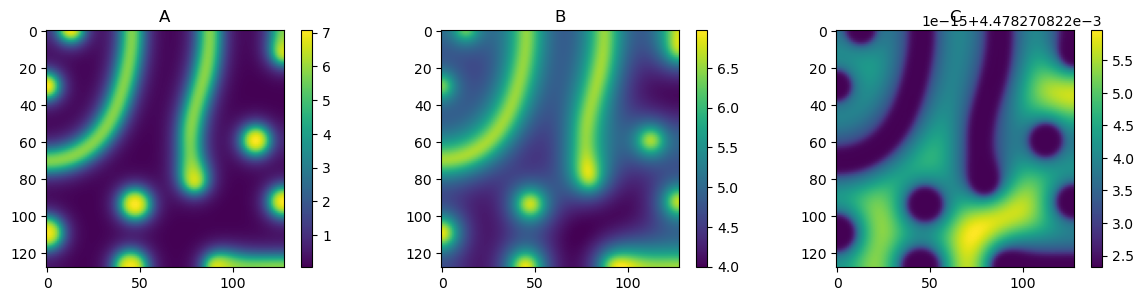

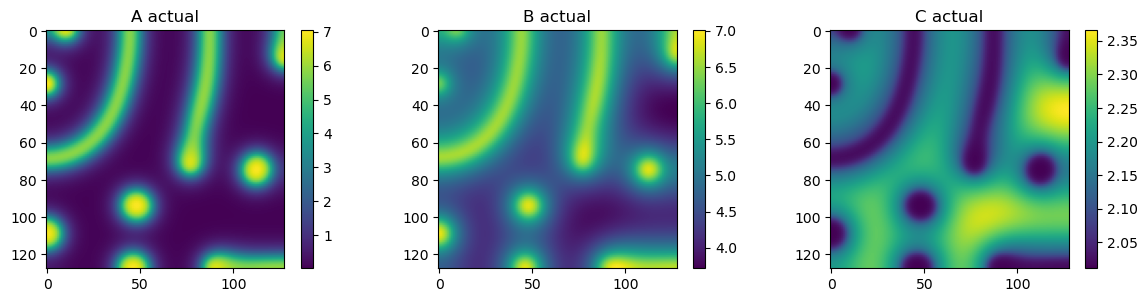

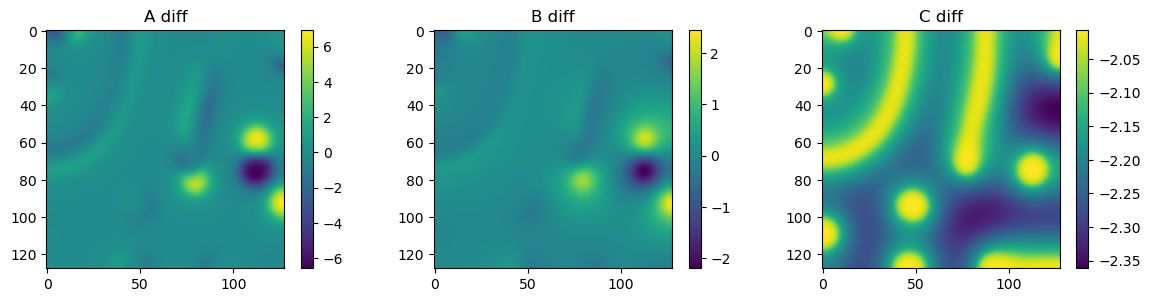

In [18]:
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")

sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import RD_2D_1st_Order, Neumann_Boundary_2D

D_A, D_B , n, mu_C= 0.01, 1.0, 4, params["mu_C"]
model_integrator = RD_2D_1st_Order(Ds=[D_A, D_B, 0], 
                        delta_t=100/5000, 
                        Lx=10, Ly=10, 
                        Ix=128, Jy=128,
                        boundary_condition=Neumann_Boundary_2D)
params2 = {}
for k,v in estimated_params.items():
    if not k.startswith("K"):
        params2[k] = v
    else:
        lower, upper = Ks_bounds[k]
        if v < lower:
            params2[k] = lower
        elif v > upper:
            params2[k] = upper
        else:
            params2[k] = v

kinetics = create_circuit_3954(n,params2["b_A"], params2["mu_A"], params2["V_A"], 
                                       params2["K_AA"], params2["K_AB"], params2["K_AC"],
                                       params2["b_B"], params2["mu_B"], params2["V_B"], 
                                       params2["K_BA"], params2["K_BC"],
                                       params2["b_C"], mu_C, params2["V_C"], 
                                       params2["K_CB"], params2["K_CC"])

(A_init, B_init, C_init) = (solution[0, 0, :, :].flatten(),
                            solution[0, 1, :, :].flatten(),
                            solution[0, 2, :, :].flatten())
solution_test = model_integrator.integrate([A_init, B_init, C_init],kinetics, 4*5000, record_steps=5000)

A_test = solution_test[-1,0, :].reshape((128,128))
B_test = solution_test[-1,1, :].reshape((128,128))
C_test = solution_test[-1,2, :].reshape((128,128))
plot_n_im([A_test,B_test,C_test], 
           ["A","B","C"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([solution[105, 0, :, :],solution[105, 1, :, :],solution[105, 2, :, :]], 
           ["A actual","B actual","C actual"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 

plot_n_im([A_test-solution[105, 0, :, :],
           B_test-solution[105, 1, :, :],
           C_test-solution[105, 2, :, :]], 
           ["A diff","B diff","C diff"],          
        figsize=(12, 3)); plt.tight_layout();plt.show() 